In [47]:
%%capture log1
! python 1_train_classifier.py 

In [48]:
! python 2_extract_tiled_kernel.py 

Instructions for updating:
non-resource variables are not supported in the long term

{'checkpoint_path': 'checkpoints/quickdraw_tiled_nonneg/20221025-153317/model.ckpt-10000',
 'kernel_count': 16,
 'kernel_pad_amount': 4,
 'kernel_size': 32,
 'spatial_kernel_path': 'assets/quickdraw16_tiledpsf.npy'}

Loaded classifier weights from checkpoints/quickdraw_tiled_nonneg/20221025-153317/model.ckpt-10000

Variable (DT_INT32) []
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
h_conv1/kernel_00 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_00/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_00/Adam_1 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_01 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_01/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_01/Adam_1 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_02 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_02/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_02/Adam_1 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_03 (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_03/Adam (DT_FLOAT) [32,32,1,1]
h_conv1/kernel_03/Adam_1 (DT_F

In [49]:
%%capture log3
! python 3_gen_maskopt_dataset.py 

In [50]:
%%capture log4
! python 4_maskopt.py 

In [51]:
! python 5_extract_phasemask_heights.py 

Instructions for updating:
non-resource variables are not supported in the long term

{'checkpoint_path': 'checkpoints/maskopt/quickdraw16_tiledpsf_4x/20221025-153448/PhaseMask_ONN.ckpt-200000',
 'image_size': 192,
 'phase_mask_heights_path': 'assets/quickdraw16_phase_mask_heights.npy',
 'phase_mask_size': 768,
 'phase_mask_size_name': 'model/maskopt/phase_mask_height/height_map_sqrt',
 'refraction_index': 1.509,
 'scale': 4,
 'wavelength': 5.5e-07}

Loaded phase mask heights from checkpoints/maskopt/quickdraw16_tiledpsf_4x/20221025-153448/PhaseMask_ONN.ckpt-200000

Variable (DT_INT32) []
beta1_power (DT_FLOAT) []
beta2_power (DT_FLOAT) []
model/maskopt/phase_mask_height/height_map_sqrt (DT_DOUBLE) [1,768,768,1]
model/maskopt/phase_mask_height/height_map_sqrt/Adam (DT_DOUBLE) [1,768,768,1]
model/maskopt/phase_mask_height/height_map_sqrt/Adam_1 (DT_DOUBLE) [1,768,768,1]

# Total number of params: 1769475
min: 0.0, max: 0.011068216361403996, mean: 3.5367458801546665e-06, std: 8.636876758

# Target PSF preparation for phase mask optimization

In [52]:
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
# from scipy.misc import imsave
# from scipy.misc import imresize

from scipy.ndimage import convolve
from skimage.transform import resize
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

def imresize(im, size):
    return resize(im, size, order=3)

from imageio import imwrite

def imsave(path, im):
    imwrite(path, im)

import tensorflow as tf

import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()

from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file

def print_tensors_in_ckpt(ckpt_path):
    print_tensors_in_checkpoint_file(
        ckpt_path, 
        tensor_name='', 
        all_tensors=False
    )
    
def load_variable_from_checkpoint(tensor_name, shape, ckpt_path, dtype=tf.float64):
    tf1.reset_default_graph()

    # Load checkpoint from disk to compare phase shifts found by tensorflow
    tensor_graph = tf1.get_variable(tensor_name, shape=shape, dtype=dtype)
    with tf1.Session() as sess:
        saver = tf1.train.Saver([tensor_graph])
        saver.restore(sess, ckpt_path)
        
        tensor_value = sess.run(tensor_graph)

    return tensor_value

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Visualization of training dataset

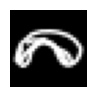

1599 0 255


In [53]:
train_data = np.load('assets/quickdraw16_test.npy') # can use train dataset instead if downloaded
i = np.random.randint(0, np.shape(train_data)[0])
i = np.shape(train_data)[0]-1
I = np.reshape(train_data[i], (28,28))


plt.imshow(I, cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(1, 1)
plt.show()
print(i, np.min(I), np.max(I))

# Visualization of classifier tiled kernel

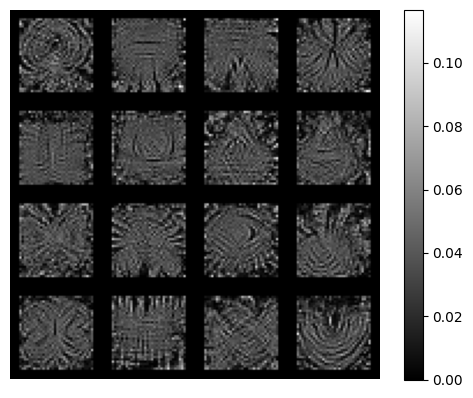

In [54]:
tiledpsf = np.load('./assets/quickdraw16_tiledpsf.npy')
plt.imshow(tiledpsf, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

# Visualization of phase mask 

In [55]:
phase_mask_heights = np.load('./assets/quickdraw_phase_mask_heights.npy')
phase_mask_heights.shape

(768, 768)

0.009612661820842387 0.0 mean: 4.334211097900264e-06


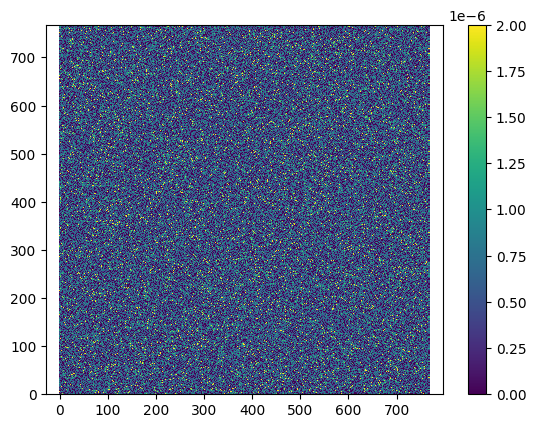

In [56]:
print(np.max(phase_mask_heights), np.min(phase_mask_heights), 'mean:', np.mean(phase_mask_heights))
plt.pcolor(phase_mask_heights, vmin=0, vmax=2e-6)
plt.colorbar()
plt.axis('equal')
plt.show()

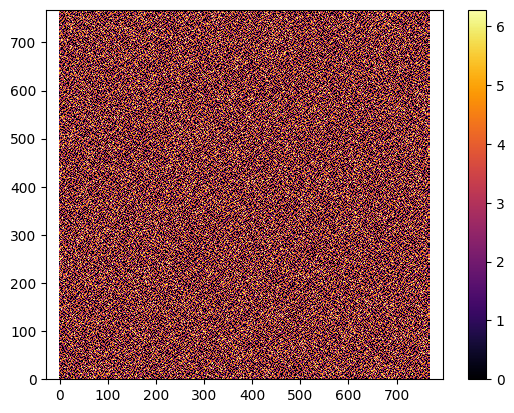

In [57]:
# Visualize phase mask instead
wavelength = 550 * 1e-9
n = 1.5090
delta_n = n - 1.0002777
phi = (2*np.pi*delta_n/wavelength) * phase_mask_heights
phimax = 2*np.pi;
phi = np.mod(phi, phimax)

plt.pcolor(phi, vmin=0, vmax=phimax, cmap='inferno')
plt.colorbar()
plt.axis('equal')
plt.show()


In [58]:
# phase mask PSF
otf = np.fft.ifftshift(np.exp(1j*phi))
psf_optical = np.square(np.abs(np.fft.ifft2(otf)))
psf_optical = np.fft.fftshift(psf_optical)
psf_optical = psf_optical[64:-64,64:-64]
print("psf in range [{:.2e},{:.2e}]".format(psf_optical.min(), psf_optical.max()))

psf in range [3.84e-13,1.24e-04]


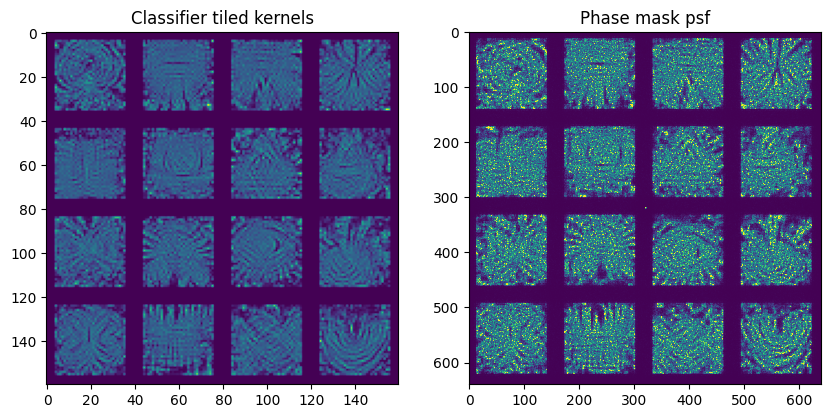

In [59]:
f, (a1,a2) = plt.subplots(1,2, figsize=(10,5))
a1.imshow(tiledpsf)
a2.imshow(psf_optical, vmax=1e-5)
a1.set_title("Classifier tiled kernels")
a2.set_title("Phase mask psf");